# Part 3: Regression with Multiple Linear Algorithm
By Josh Houlding

Often, you may want to train your model using more than one independent variable and a label. This is known as multiple regression, in which two or more independent variables are used to predict the value of a dependent variable. Some real-world examples of its use include predicting next year's Gross National Product (GNP) based on last year's GNP, current interest rate, unemployment, and some other variables.

To demonstrate completion of this assignment, create a Microsoft Word document with your working code, screenshots of program results, and written answers to questions. Writing should be professional and rigorous, and include scientific/mathematical justification, where appropriate, for all conclusions reached. Upload your final Jupyter notebook and Word document to the digital classroom when complete.

For this activity, in 250-500 words, answer the following:
1. Make sure all necessary libraries are loaded. Print your x (independent) and y (dependent) variables from the data frame. Show the results.
2. Fit an ordinary least square method using the OLS method from the seaborn library to figure out your most significant variables. Show the results and interpret the following:
    - R-squared
    - Adjusted. R-Squared
    - Degree of freedom
    - Coefficient of determination and P-values
3. Test, identify, and detect multicollinearity in your dataset. Explain how you resolved it and report the results.
4. Fit a linear regression model using the linear regression method from scikit-learn library. Obtain the coefficients and interpret the results.
5. Split the data into 80% training and 20% testing sets using the train_test_split class.
6. Train the multiple regression model on the training set using the LinearRegression class.
7. Make regression predictions and interpret your results in the context of the question(s) you're trying to answer.
8. Validate your multiple regression model using a confusion matrix, accuracy score, and k-fold cross-validation.

# Task 1
Make sure all necessary libraries are loaded. Print your x (independent) and y (dependent) variables from the data frame. Show the results.

Dataset: <a href="https://www.kaggle.com/datasets/suyashlakhani/apple-stock-prices-20152020">https://www.kaggle.com/datasets/suyashlakhani/apple-stock-prices-20152020</a>

In [23]:
# Import general libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt

# Import modeling libraries
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Import diagnostic and evaluation libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [24]:
# Load data
df = pd.read_csv("AAPL.csv")

# Drop redundant columns
df = df.drop(columns={"Unnamed: 0", "symbol"})

# View data
df.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


I was curious if all date values contain the time value "00:00:00+00:00". If so, it can be removed for brevity. 

In [25]:
# Find count of "00:00:00+00:00"
string = "00:00:00+00:00"
count = 0
for date in df["date"]: 
    if string in str(df["date"]): 
        count += 1
print(f"Dates: {len(df)}")
print(f"Dates containing \"00:00:00+00:00\": {count}")

Dates: 1258
Dates containing "00:00:00+00:00": 1258


All dates do contain this value, so it is redundant and can be removed. 

In [26]:
# Remove "00:00:00+00:00" from dates
df["date"] = df["date"].str.slice(0, 10)
df["date"] = df["date"].str.strip()

# Convert dates to datetime format
df["date"] = pd.to_datetime(df["date"])

In [27]:
# Show updated dates
df["date"].head(3)

0   2015-05-27
1   2015-05-28
2   2015-05-29
Name: date, dtype: datetime64[ns]

In [28]:
# Create new features from "date" column
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.dayofweek

# Function to map month to financial quarter
def get_financial_quarter(month): 
    if 1 <= month <= 3: 
        return 1
    elif 4 <= month <= 6: 
        return 2
    elif 7 <= month <= 9: 
        return 3
    else:
        return 4

# Create new feature for financial quarter
df["quarter"] = df["month"].apply(get_financial_quarter)

# Drop "date" column
df = df.drop(columns={"date"})

In the previous assignment, I found considerable multicollinearity between each "regular" variable (`close`, `high`, etc.) and its adjusted counterpart (`adjClose`, `adjHigh`, etc.). Thus, I believe it would be appropriate to remove either the "regular" variables or the adjusted ones, and I have opted to remove the adjusted ones for simplicity. Let's do that now: 

In [29]:
# Drop adjusted variables
df = df.drop(columns={"adjClose", "adjHigh", "adjLow", "adjOpen", "adjVolume"})

In [30]:
# Reorder columns in dataframe
df = df[["year", "month", "day", "day_of_week", "quarter", "high", "low", "open", "volume", "divCash", "splitFactor", "close"]]

In [31]:
# Show final dataframe for modeling
df.head()

,year,month,day,day_of_week,quarter,high,low,open,volume,divCash,splitFactor,close
0,2015,5,27,2,2,132.260,130.05,130.34,45833246,0.0,1.0,132.045
1,2015,5,28,3,2,131.950,131.10,131.86,30733309,0.0,1.0,131.780
2,2015,5,29,4,2,131.450,129.90,131.23,50884452,0.0,1.0,130.280
3,2015,6,1,0,2,131.390,130.05,131.20,32112797,0.0,1.0,130.535
4,2015,6,2,1,2,130.655,129.32,129.86,33667627,0.0,1.0,129.960


Now, let's display our dependent and independent variables. We are trying to predict the closing price of Apple's stock using various financial and time-based factors. 

<b>Independent variables:</b> `year`, `month`, `day`, `day_of_week`, `quarter`, `high`, `low`, `open`, `volume`, `divCash`, `splitFactor` <br>
<b>Dependent variable:</b> `close` 

# Task 2
Fit an ordinary least square method using the OLS method from the seaborn library to figure out your most significant variables. Show the results and interpret the following:
* R-squared
* Adjusted. R-Squared
* Degrees of freedom
* Coefficients of determination and P-values

In [32]:
# Define independent and dependent variables
x = df[["year", "month", "day", "day_of_week", "quarter", "high", "low", "open", "volume", "divCash", "splitFactor"]]
y = df["close"]

# Add constant for intercept estimation
x = sm.add_constant(x)

# Fit OLS model
model = sm.OLS(y, x).fit()

# Show model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.589e+05
Date:                Thu, 28 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:19:50   Log-Likelihood:                -2062.5
No. Observations:                1258   AIC:                             4147.
Df Residuals:                    1247   BIC:                             4204.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
year           -0.0445      0.059     -0.750      0.453      -0.161       0.072
month          -0.0507      0.044     -1.159      0.247      -0.137       0.035
day            -0.0066      0.004     -1.618      0.106      -0.015       0.001
day_of_week    -0.0088      0.026     -0.343      0.732      -0.059       0.041
quarter         0.1847      0.134      1.381      0.167      -0.078       0.447
high            0.7786      0.025     31.056      0.000       0.729       0.828
low             0.7623      0.025     30.197      0.000       0.713       0.812
open           -0.5401      0.026    -20.718      0.000      -0.591      -0.489
volume      -5.065e-09   2.99e-09     -1.692      0.091   -1.09e-08    8.08e-10
divCash         0.6596      0.431      1.530      0.126      -0.186       1.505
splitFactor    89.8205    119.540      0.751      0.453    -144.701     324.342
==============================================================================
Omnibus:                      425.057   Durbin-Watson:                   2.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27429.158
Skew:                          -0.692   Prob(JB):                         0.00
Kurtosis:                      25.834   Cond. No.                     1.32e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b>$R^2$ and $R^{2}_{adj}$:</b> We see that both of these values are 1.0, meaning the independent variables capture 100% of the variance in the dependent variable. This suggests a massive amount of overfitting to the training data, unless our model is flawless, which is extremely unlikely. This could be remedied by a train-test split. 

<b>Degrees of Freedom:</b> The degrees of freedom for the model is 10, and for the residuals it is 1,247. 
* Model: The df of the model represent the total number of parameters estimated in the model, including the intercept. 
* Residuals: The df of the residuals represent the number of observations minus the number of parameters in the model. 

<b>Coefficients of determination:</b> These values represent the regression coefficients for the independent variables, which are the proportions of variance in the dependent variable that is explained by each independent variable. 

<b>P-values:</b> The P-values ($P > |t|$) for each independent variable represent the probability that its coefficient is equal to zero. The null hypothesis is that the coefficient is zero, IE that variable has no effect on the dependent variable, and the alternative hypothesis is that the coefficient is nonzero, IE that it has an effect. 

# Task 3
Test, identify, and detect multicollinearity in your dataset. Explain how you resolved it and report the results.

In [33]:
# Show variables before dropping
df.head(0)

,year,month,day,day_of_week,quarter,high,low,open,volume,divCash,splitFactor,close


We can write a function to automatically drop variables with VIFs above a certain threshold.

In [34]:
# Function to drop variables with high VIFs 
def drop_high_vif_variables(data_frame, threshold=10):
    features = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    high_vif_variables = vif_data[vif_data["VIF"] > threshold]["Variable"].values
    data_frame_dropped = data_frame.drop(high_vif_variables, axis=1)
    return data_frame_dropped

# Store label "close" so it doesn't get removed
close = df.pop("close")

# Drop variables with high VIFs from the dataframe
df = drop_high_vif_variables(df)

# Add "close" back onto the end
df["close"] = close

In [35]:
# Show variables after dropping
df.head(0)

,year,day,day_of_week,volume,divCash,close


We see that `year`, `day`, `day_of_week`, `volume` and `divCash` are the only independent variables that are not strongly correlated with other variables, and thus do not contribute significantly to multicollinearity. 

# Task 4
Fit a linear regression model using the linear regression method from scikit-learn library. Obtain the coefficients and interpret the results.

In [36]:
# Get independent and dependent variables
x = df[["year", "day", "day_of_week", "volume", "divCash"]]
y = df["close"]

# Create and fit model
model = LinearRegression()
model.fit(x, y)

# Show model coefficients, intercept and R^2
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2:", model.score(x, y))

Coefficients: [ 3.34917100e+01  6.10537023e-02 -1.98012547e-01  1.04988877e-07
  7.26743862e+00]
Intercept: -67402.51855928185
R^2: 0.7691375609650263


Our model equation is approximately the following: $close = -67403 + 33.5*year + 0.06*day - 0.2*dayofweek + (1.05*10^{-7})*volume + 7.27*divCash$.

# Task 5
Split the data into 80% training and 20% testing sets using the train_test_split class.

In [37]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Task 6
Train the multiple regression model on the training set using the LinearRegression class.

In [38]:
# Train model using training data
model.fit(x_train, y_train)

# Show model coefficients, intercept and R^2
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2:", model.score(x, y))

Coefficients: [3.33076592e+01 1.46098202e-01 6.65736055e-02 1.11003062e-07
 2.78559429e+00]
Intercept: -67032.80959220306
R^2: 0.7687782776329796


# Task 7
Make regression predictions and interpret your results in the context of the question(s) you're trying to answer.

In [39]:
# Assemble dataframe with predictions and actual values
predictions_vs_actual = pd.DataFrame({
    "actual": y, 
    "predicted": model.predict(x)
})

# Calculate residuals
predictions_vs_actual["residual"] = predictions_vs_actual["actual"] - predictions_vs_actual["predicted"]

# Show results
predictions_vs_actual.head()

,actual,predicted,residual
0,132.045,91.289092,40.755908
1,131.780,89.825625,41.954375
2,130.280,92.275135,38.004865
3,130.535,85.834380,44.700620
4,129.960,86.219642,43.740358


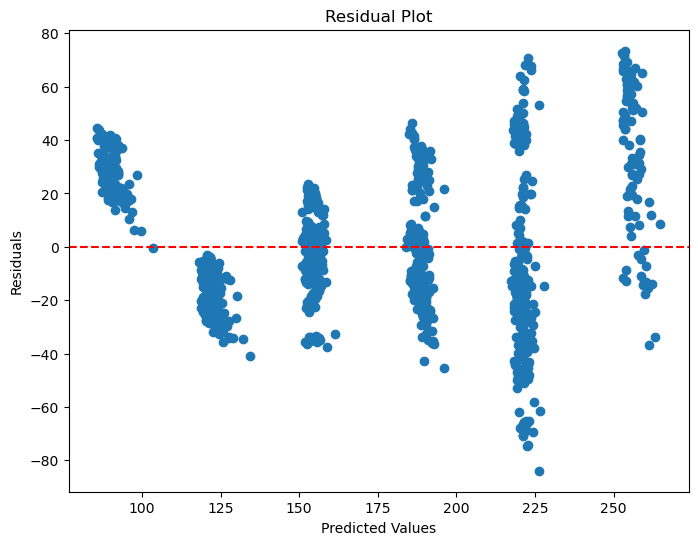

Descriptive statistics for the residuals:
           count      mean        std        min        25%       50%  \
residual  1258.0 -0.445139  27.333374 -83.938248 -18.259928 -6.613274   

                75%        max  
residual  20.567201  73.495613  


In [40]:
# Create residual plot
plt.figure(figsize=(8, 6))
plt.scatter(predictions_vs_actual["predicted"], predictions_vs_actual["residual"])
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# Show residual descriptive statistics
print("Descriptive statistics for the residuals:")
print(predictions_vs_actual["residual"].describe().to_frame().transpose())

We see a cone-shaped distribution of residuals, suggesting possible heteroscedasticity. To correct this issue, we could perform transformations on the dependent variable `close`, or use an alternative regression technique like weighted least squares that is less prone to heteroscedasticity issues. 

We also notice that the mean residual is close to 0, demonstrating that the model's <i>average</i> prediction is accurate, but the individual predictions are often far too high or too low, as evidenced by the standard deviation. 

# Task 8
Validate your multiple regression model using a confusion matrix, accuracy score, and k-fold cross-validation.

Confusion matrices and accuracy scores are primarily used for classification machine learning models, not regression models, so we will need to validate the model's effectiveness using other metrics. These could include the mean squared error (MSE), root mean squared error (RMSE), and mean absolute error (MAE). We will include these along with k-fold cross-validation scores. 

In [46]:
# Shortenings of actual and predicted values
actual = predictions_vs_actual["actual"]
predicted = predictions_vs_actual["predicted"]

# Calculate MSE, RMSE and MAE
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)

# Calculate k-fold cross-validation scores
scores = cross_val_score(model, x, y, cv=5)

# Show MSE, RMSE and MAE metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Cross-Validation Scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())

Mean Squared Error (MSE): 746.717576404666
Root Mean Squared Error (RMSE): 27.32613357949979
Mean Absolute Error (MAE): 22.144066985465603
Cross-Validation Scores: [-13.2265556   -0.78560815  -0.46306999  -1.89026497  -0.7481862 ]
Mean Cross-Validation Score: -3.4227369821976112


These cross-validation scores represent how well the model generalizes to new, unseen data, with positive scores indicating good model performance. Our scores are all negative, meaning that the model performs worse than a naive model that always predicts the mean, median, or some other basic value. Further investigation would be required to figure out why the model's performance is poor and how to improve it. 

# References
ChatGPT. (n.d.). https://chat.openai.com/ <br>
Confusion matrix in linear regression. (n.d.). Stack Overflow. https://stackoverflow.com/questions/62077965/confusion-matrix-in-linear-regression